# Wine Quality Classification Final Submission

## 1. Domain Proyek
Proyek ini bertujuan untuk mengklasifikasikan kualitas wine menjadi dua kelas:
- Rendah (Low Quality, 0)
- Tinggi (High Quality, 1)
berdasarkan fitur kimiawi seperti keasaman, pH, kadar alkohol, dan lain-lain.

**Sumber Data:** UCI Machine Learning Repository
URL: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

## 2. Business Understanding
**Permasalahan:**
Produsen wine ingin mengoptimalkan produksi dengan memprediksi kualitas produk berdasarkan parameter kimia selama proses produksi.

**Goal:**
Mengembangkan model klasifikasi untuk memprediksi apakah wine berkualitas tinggi atau rendah.

**Solution Statement:**
- Membandingkan model Decision Tree, Random Forest, dan XGBoost.
- Menggunakan SMOTE untuk mengatasi imbalance.
- Evaluasi dengan Accuracy, Precision, Recall, F1-Score, AUC.

## 3. Data Understanding
- **Jumlah Data:**
  - Baris: 6497
  - Kolom: 13

- **Kondisi Data:**
  - Tidak ada missing value
  - Terdapat duplikat data

- **Fitur:**
  1. fixed acidity
  2. volatile acidity
  3. citric acid
  4. residual sugar
  5. chlorides
  6. free sulfur dioxide
  7. total sulfur dioxide
  8. density
  9. pH
  10. sulphates
  11. alcohol
  12. type (jenis wine)
  13. quality (nilai kualitas)


In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [3]:
# 2. Load & Combine Dataset
red = pd.read_csv("winequality-red.csv", sep=';')
white = pd.read_csv("winequality-white.csv", sep=';')
red['type'], white['type'] = 'red', 'white'
wine = pd.concat([red, white], axis=0)
wine['quality_label'] = wine['quality'].apply(lambda x: 1 if x >= 7 else 0)
wine.shape, wine.isnull().sum(), wine.duplicated().sum()


((6497, 14),
 fixed acidity           0
 volatile acidity        0
 citric acid             0
 residual sugar          0
 chlorides               0
 free sulfur dioxide     0
 total sulfur dioxide    0
 density                 0
 pH                      0
 sulphates               0
 alcohol                 0
 quality                 0
 type                    0
 quality_label           0
 dtype: int64,
 np.int64(1177))

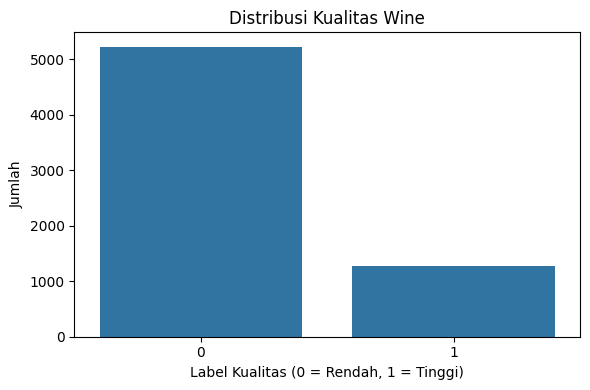

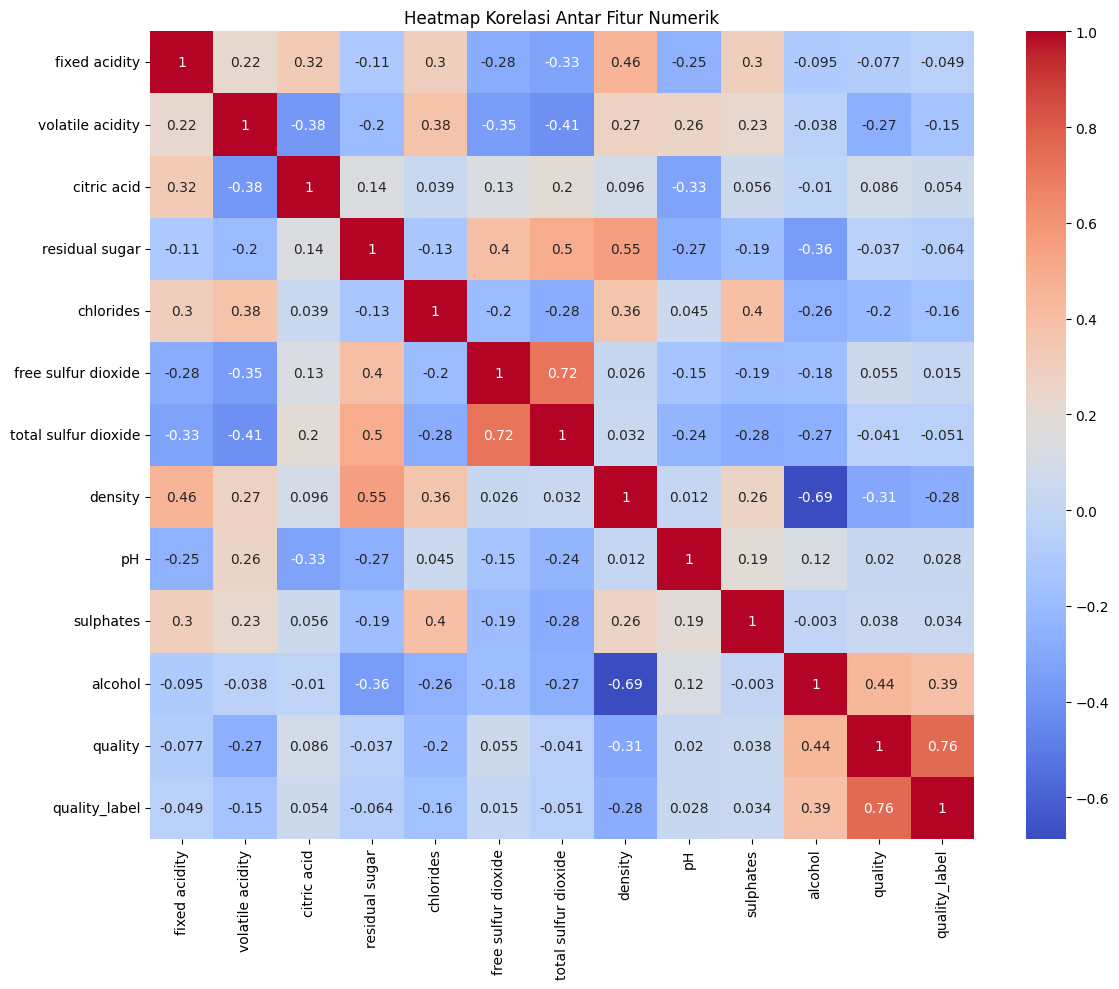

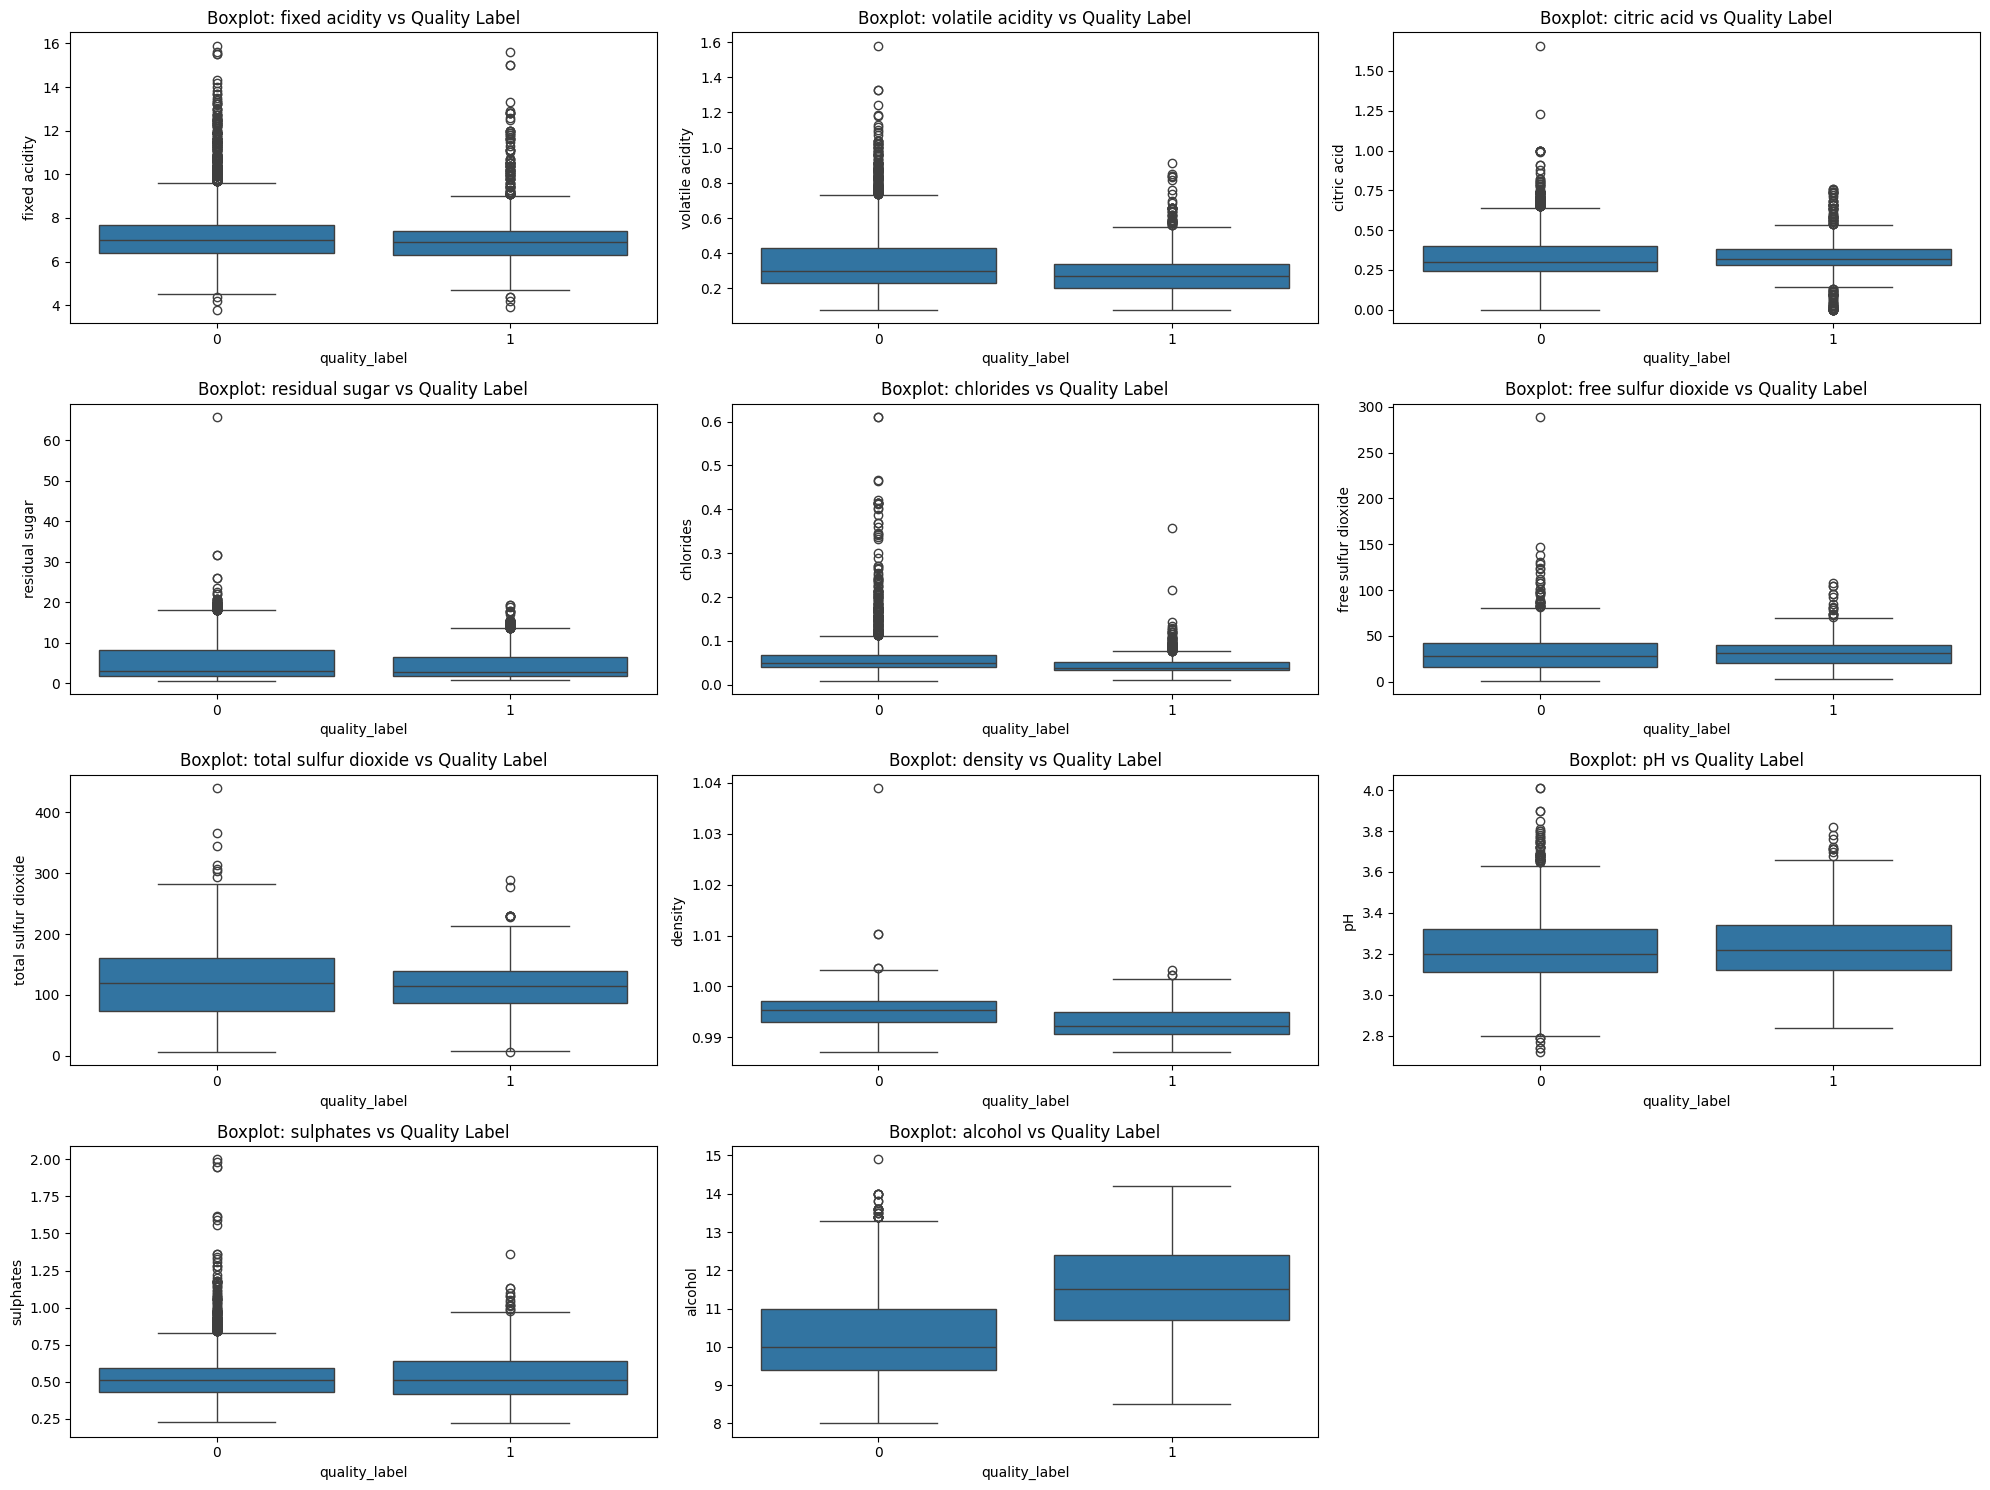

In [5]:
# 3. Exploratory Data Analysis (EDA)

# Distribusi label
plt.figure(figsize=(6, 4))
sns.countplot(x='quality_label', data=wine)
plt.title("Distribusi Kualitas Wine")
plt.xlabel("Label Kualitas (0 = Rendah, 1 = Tinggi)")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

# Korelasi antar fitur (filter kolom numerik saja)
plt.figure(figsize=(12, 10))
numerical_cols = wine.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Antar Fitur Numerik")
plt.tight_layout()
plt.show()

# Boxplot per fitur numerik
features = wine.select_dtypes(include=['float64', 'int64']).drop(columns=['quality', 'quality_label']).columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(features):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x='quality_label', y=col, data=wine)
    plt.title(f"Boxplot: {col} vs Quality Label")
plt.tight_layout()
plt.show()

## 4. Data Preparation
Tahapan preprocessing data meliputi:
- **Handling outlier:** Menghapus nilai outlier menggunakan metode IQR.
- **Splitting data:** Memisahkan data menjadi train dan test set (80:20).
- **Scaling:** Menormalkan fitur numerik menggunakan StandardScaler.
- **Balancing:** Menggunakan SMOTE untuk mengatasi data imbalance.

In [7]:
# Hapus outlier
numerical_cols = wine.select_dtypes(include=["float64", "int64"]).drop(columns=["quality", "quality_label"]).columns

def remove_outliers(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
    return cleaned_df

wine_cleaned = remove_outliers(wine, numerical_cols)

wine_clean = remove_outliers(wine.copy(), numerical_cols)

# Feature & Target
X = wine_clean.drop(['quality', 'quality_label', 'type'], axis=1)
y = wine_clean['quality_label']

# Train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# SMOTE
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

## 5. Modeling
### Model 1: Decision Tree Classifier
**Cara kerja:**
- Membuat pohon keputusan berdasarkan fitur yang memisahkan kelas sebaik mungkin.
**Parameter:**
- `criterion='gini'` (default)
- `random_state=42`
**Kelebihan:**
- Interpretatif dan mudah divisualisasikan.
**Kekurangan:**
- Mudah overfitting tanpa pruning.

### Model 2: Random Forest Classifier
**Cara kerja:**
- Ensemble dari banyak pohon keputusan yang di-train pada subset berbeda.
**Parameter:**
- `n_estimators=100` (default)
- `random_state=42`
**Kelebihan:**
- Lebih akurat dan tahan overfitting.
**Kekurangan:**
- Lebih sulit diinterpretasikan.

### Model 3: XGBoost Classifier
**Cara kerja:**
- Ensemble boosting berbasis optimasi gradient.
**Parameter:**
- `use_label_encoder=False`
- `eval_metric='logloss'`
**Kelebihan:**
- Performa tinggi di tabular data.
**Kekurangan:**
- Kompleks dalam tuning hyperparameter.

In [8]:

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_smote, y_train_smote)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:49:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## 6. Evaluation


Decision Tree:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       725
           1       0.56      0.75      0.64       195

    accuracy                           0.82       920
   macro avg       0.74      0.80      0.76       920
weighted avg       0.85      0.82      0.83       920



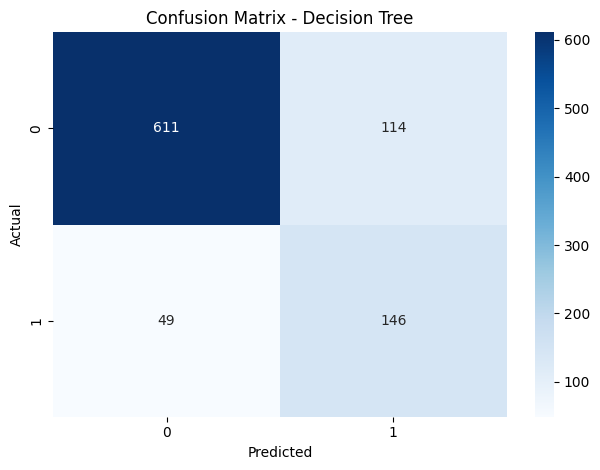


Random Forest:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       725
           1       0.67      0.76      0.71       195

    accuracy                           0.87       920
   macro avg       0.80      0.83      0.81       920
weighted avg       0.88      0.87      0.87       920



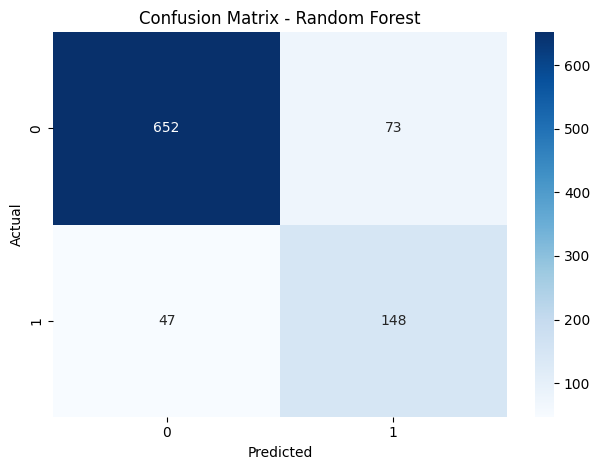


XGBoost:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       725
           1       0.65      0.71      0.68       195

    accuracy                           0.86       920
   macro avg       0.79      0.80      0.79       920
weighted avg       0.86      0.86      0.86       920



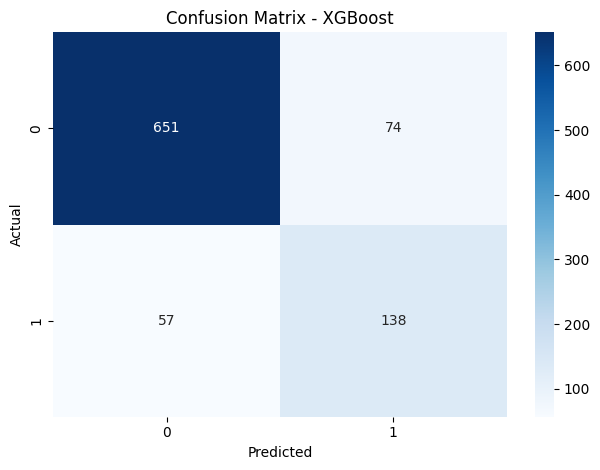

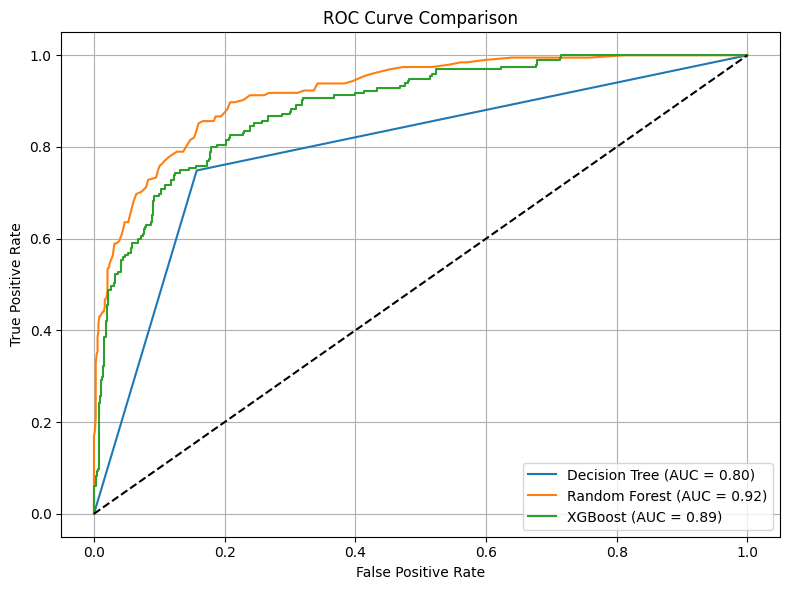

In [10]:
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

for name, model in models.items():
    print(f"\n{name}:")
    y_pred = model.predict(X_test_scaled)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# ROC Curve
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
